# Toolchain for Compressed Air Energy Storage

In this example the toolchain is used to derive a consistent Reservoir Model for the adiabatic compressed air energy storage LTA-CAES&#174;.

The picture shows the 5 steps of the toolchain, which are executed below

![image.png](img/overview_toolchain.png)

Starting with a real energy storage system, the steps are:
- [Selecting the experimental design](##selecting-the-experimental-design)
- [Execute the experimental design](##Execute-the-experimental-design)
- [Analyze the results](#Analyze-the-results)
- [Set up the optimization model](#Set-up-the-optimization-model) 
- [Evaluate the optimization model](#evaluate-the-optimization-model)

## Selecting the experimental design

In order to design a comprehensive and at the same time compact experimental plan, we analyzed and researched which factors can affect the charging, storage and discharging efficiency of a compressed air energy storage. The potential influencing factors, that where analyzed are show in the table below

|factor|description|unit|
|--|--|--|
|`P_{in,rel}`|relative electic charging power|-|
|`P_{out,rel}`|relative electic discharging power|-|
|`Phi`|relative humidity|%|
|`SOC_{delta}`|difference of the State of Charge between `t_{start}` and `t_{end}`|-|
|`SOC_{init}`|initial State of Charge at `t_{start}`|-|
|`T_{ambient}`|ambient temperature|K|
|`t_{sp}`|duration of storage|s|

For each experimental design, the Advanced Latin Hyper Cube Sampling is applied. In order to generate a sufficiently large database for statistical evaluation, approximately 700 simulation runs / samples are required. Due to constraints during charging and discharging, approximately 50% of the simulation runs are solved, therefore 1500 runs are needed.

| factor | Charging min | Charging max | Discharging min | Discharging max | Storing min | Storing max|
|--|--|--|--|--|--|--|
|`P_{in,rel}`|0.663|1.04|-|-|-|-|
|`P_{out,rel}`|-|-|0.38|1.08|-|-|
|`SOC_{delta}`|0.05|0.9|0.05|0.95|-|-|
|`SOC_{init}`|0.1|0.95|0.05|1|0|1|
|`t_{sp}`|-|-|-|-|0|604800|

with the constraint that $SOC_{delta} \le 1-SOC_{init}$

| factor | min | max | 
|--|--|--|
|`T_{ambient}`|278.15|298.15|
|`Phi`|0|100|

Go to [Overview](#overview)

## Execute the experimental design

The calculations are carried out using a dynamic simulation model. The optiS-Lang (2021 R1) software is used to automate the creation and execution of the test plans and is linked to the Dymola simulation software.

The results of the simulation runs can be found in the folder `design_plan_simulation_results` for charging, storing and discharging.

Go to [Overview](#overview)

## Analyze the results

The impact of the different influencing factors was determined using the CoP. The CoP values for the charging, storing and discharging are shown below:

|parameter|`P_{in/out}`|`SOC_{init}`|`t_{sp}`|`T_{amb}`|`Phi`|
|--|--|--|--|--|--|
|`eta_{in}`|86.7 %|-|-|8.1 %|6.3 %|
|`eta_{stor}`|-|65.4 %|52.6 %|-|-|
|`eta_{out}`|99.5 %|-|-|-|-|-|

In the following modeling the influence of the power on charging and discharging efficiency are modeled. Since the significance of th ambient temperature and humidity are comparatively low, they are neglected in the following. The influence of the state of charge and storage duration on the storage efficiency are analyzed and integrated in the storage model.

Go to [Overview](#overview)

## Set up the optimization model

The dependency of the charging and discharging effinciency on the storage power is modeled analogues to the [pumped hydro storage model](toolchain_with_phs_example.ipynb).

To account for storage losses, the calculation of the state of charge is extended by multiplying the state of charge of the previous timestep with $\eta_{stor}$ to get the state of charge that remains in the storage:

$$\,\,\,\, soc(t) = soc(t-1)\cdot \eta_{stor}+ E_{in}(t) - E_{out}(t)$$

The experimental design shows a relation between the storage losses $\eta_{stor}$ and the initial state of charge $soc_{ini}$. In the optimization model, the initial state of charge corresponds to the state of charge at the beginning of a timesteps, which is equal to the state of charge of the timestep before:

$$\,\,\,\, \eta_{stor}(t) = f(soc(t-1))$$

This again leads to a non-linear problem formulation:

$$\,\,\,\, soc(t) = soc(t-1) \cdot \eta_{stor}(soc(t-1)) + E_{in}(t) - E_{out}(t)$$

As before we can rewrite this by calculating the losses directly depending on the state of charge:

$$\,\,\,\, soc_{loss}(t) = soc(t-1)\cdot (1-\eta_{stor}(soc(t-1)))$$

$$\,\,\,\, soc(t) = soc(t-1) - soc_{loss}(soc(t-1)) + E_{in}(t) - E_{out}(t)$$

With the data available from the experimental design we can calculate $soc_{loss}$ for all $soc$ and use this relation directly.

$$\,\,\,\, soc_{loss}(t) = a_{soc}(s)\cdot soc(t-1) + b_{soc}(s)$$

This function can be modelled using the SOS2 or BigM approach:

---

**storage duration**

In addition to the dependence of the storage losses on the current state of charge, the metamodel identified a significant dependence on the storage duration. In order to model this dependency we firstly calculated the storage losses per hour:

$$soc_{loss,spec}= \frac{soc_{loss}}{t_{sp}}$$ 

The calculation of specific storage losses per hour is a necessary approximation, since optimisation models have a discrete-time resolution - one time step usually corresponds to one hour. This means that the storage duration cannot be modelled directly as a dependency, as the time is not a variable or parameter of the model, but is defined by the time step length. This means that only losses per time step length can be defined

Use the code below to see, that this dependency is nearly linear.

---

All model variants can be found in the folder `src\storage_models`

---

Go to [Overview](#overview)

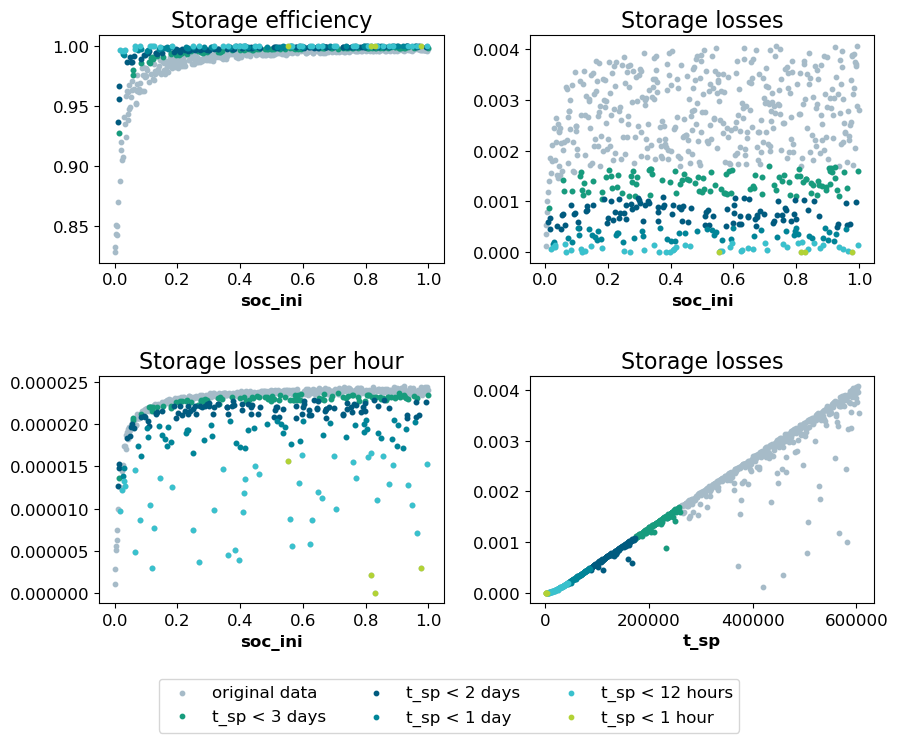

In [1]:
import os
from plots.storage_losses import plot_specific_storage_losses_sorted

# choose the data from the design plan
data_file_name = "caes_storage_losses_data.csv"
data_file_path = os.path.realpath(
    os.path.join(os.getcwd(), "design_plan_simulation_results", data_file_name)
)

plot_specific_storage_losses_sorted(data_file_path)


## Evaluate the optimization model



### Regression analysis

The correlation analysis is also used to analyse the linear relationship between factors (power, SOC, storage duration, ambient temperature and humidity) and the efficiency in the CAES model. While the dependency of the withdrawal efficiency can be mapped well by a linear dependency on the withdrawal capacity (0.91), there is no clear linear relationship between the injection efficiency and the injection capacity (0.61). The holding process can only be described to a limited extent by a linear dependence on the initial filling level and the storage duration (0.47 and -0.3 respectively).

|parameter|`P_{in/out}`|`SOC_{init}`|`t_{sp}`|`T_{amb}`|`Phi`|
|--|--|--|--|--|--|
|`eta_{in}`|0.61|-0.03|-|-0.54|-0.15|
|`eta_{stor}`|-|0.47|-0.3|-|-|
|`eta_{out}`|0.91|0.06|-|-0.02|-|-|

### Comparison of model variants

To implement different piecewise linear equations, first the optimal breakpoints have to calculated. See [this notebook](src/efficiency_parameter_calculation.ipynb) on how to do so. Below you can see the breakpoint calculation for different numbers of segments.



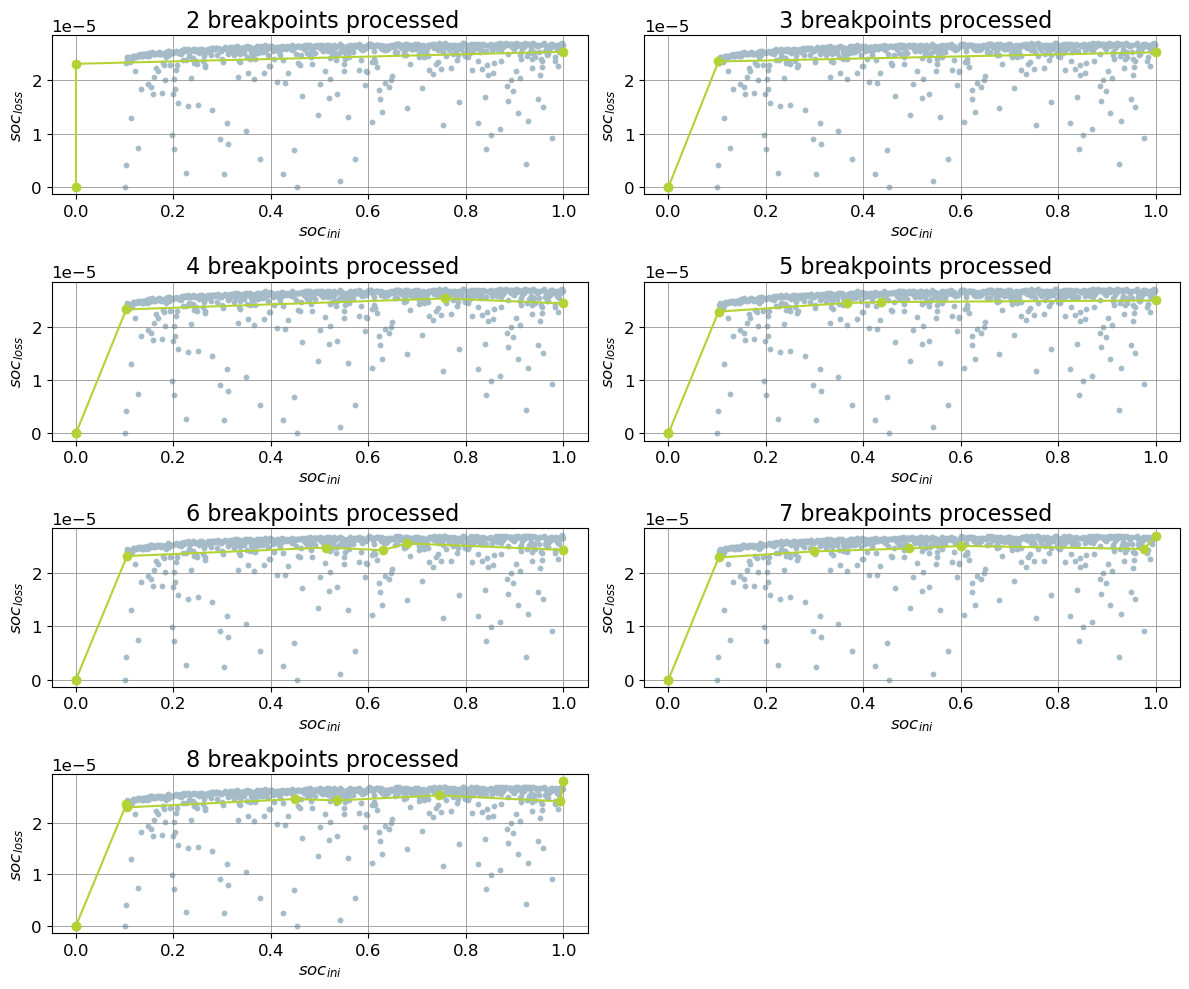

In [2]:
import os
import pandas as pd
from src.efficiency_calculation_script import loop_breakpoint_calculation
from plots.breakpoints import plot_breakpoints_as_subplots, read_data_from_csv

# choose the data from the design plan
data_file_name = "caes_storage_losses_data_1.csv"
data_file = os.path.realpath(
    os.path.join(os.getcwd(), "design_plan_simulation_results", data_file_name)
)

# define path to results file
res_file_path = os.path.realpath(
    os.path.join(
        os.getcwd(), "src", "data", "breakpoint_calculation_results", "caes_soc_losses"
    )
)

# define column labels of input data
x_value_label = "SOC_init"
y_value_label = "soc_loss_spec_hourly"

# read original data for plotting
x_data, y_data = read_data_from_csv(data_file, x_value_label, y_value_label)

# define number of breakpoints to be calculated
minimal_number_of_breakpoints = 2
maximum_number_of_breakpoints = 8

# minimum and maximum x value to bound the breakpoints
x_min = 0.00001
x_max = 1

# specify if output to terminal is to be displayed
log_msg = False

# calculate breakpoints
df_breakpoints = loop_breakpoint_calculation(
    data_file,
    res_file_path,
    x_value_label,
    y_value_label,
    minimal_number_of_breakpoints,
    maximum_number_of_breakpoints,
    x_min,
    x_max,
    res_decimals=8,
    log_msg=False,
)
# plot breakpoints

# define axis labels
x_label = "$soc_{ini}$"
y_label = "$soc_{loss}$"

# define breakpoints to plot
all_labels = df_breakpoints.columns
bp_labels = [label for label in all_labels if not label.startswith("y")]
bp_labels = [label for label in bp_labels if not label.endswith("breakpoints")]

plot_breakpoints_as_subplots(
    x_data, y_data, len(bp_labels), df_breakpoints, bp_labels, x_label, y_label
)


To understand the influence of the number of segments of the approximation on the solution time as well as on the optimization results, we looked at approximations ranging from 2 up to 6 segments, as well as constant efficiencies. For the piecewise linear approximation of the storage losses we 2 up to 4 segments.

Use [this code](src/efficiency_parameter_calculation.ipynb) to calculate constant efficiencies for your own data.

**Solution time**

Below you find the solution times for the different optimization model variants. 

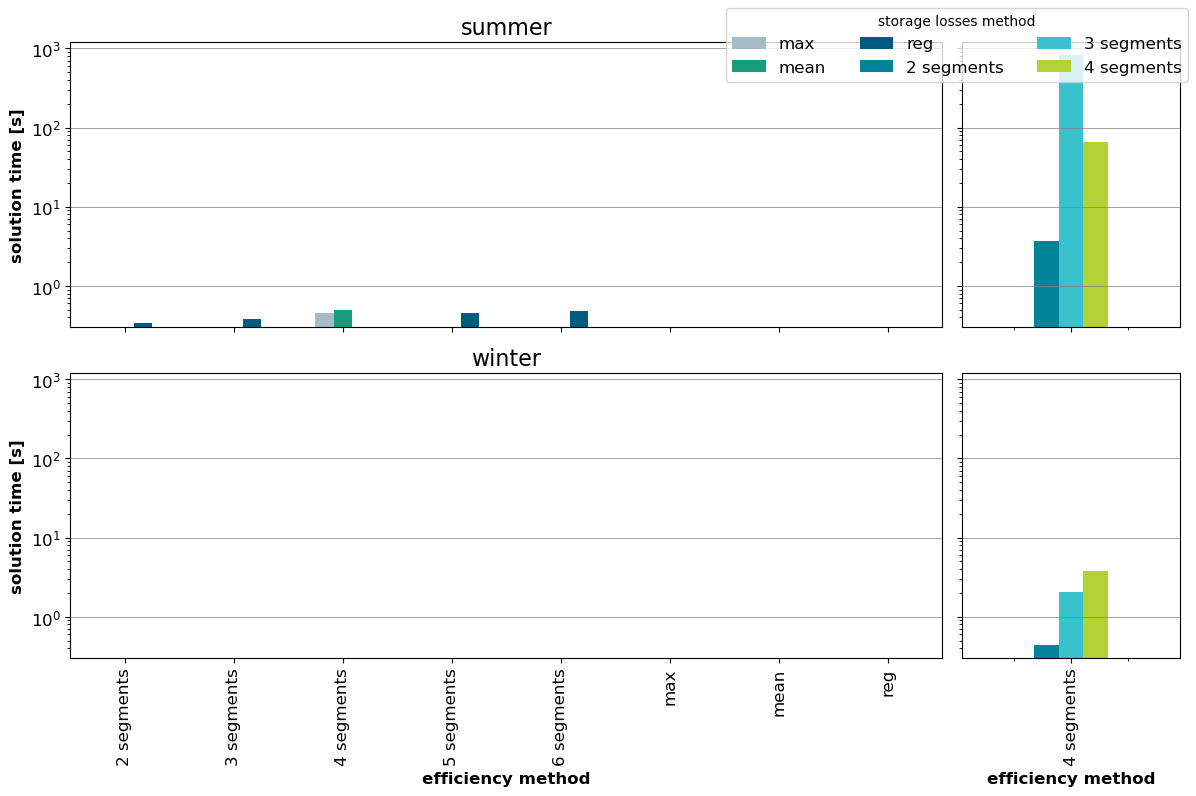

In [4]:
from plots.opt_results_comparison import (
    plot_comparison_optimization_results_caes,
)

type = "solution time"

plot_comparison_optimization_results_caes(type, "SOS2", "10 segments")


For constant storage losses the solution time is below 1 second for all variant. Using piecewise linear storage losses increases the solution time drastically.

> For reasonable solution times the storage losses should be modeled as constant.

**Objective value**

Below you find the solution times for the different optimization model variants:

Change `comparison method` and `comparison run` to set the reference run.

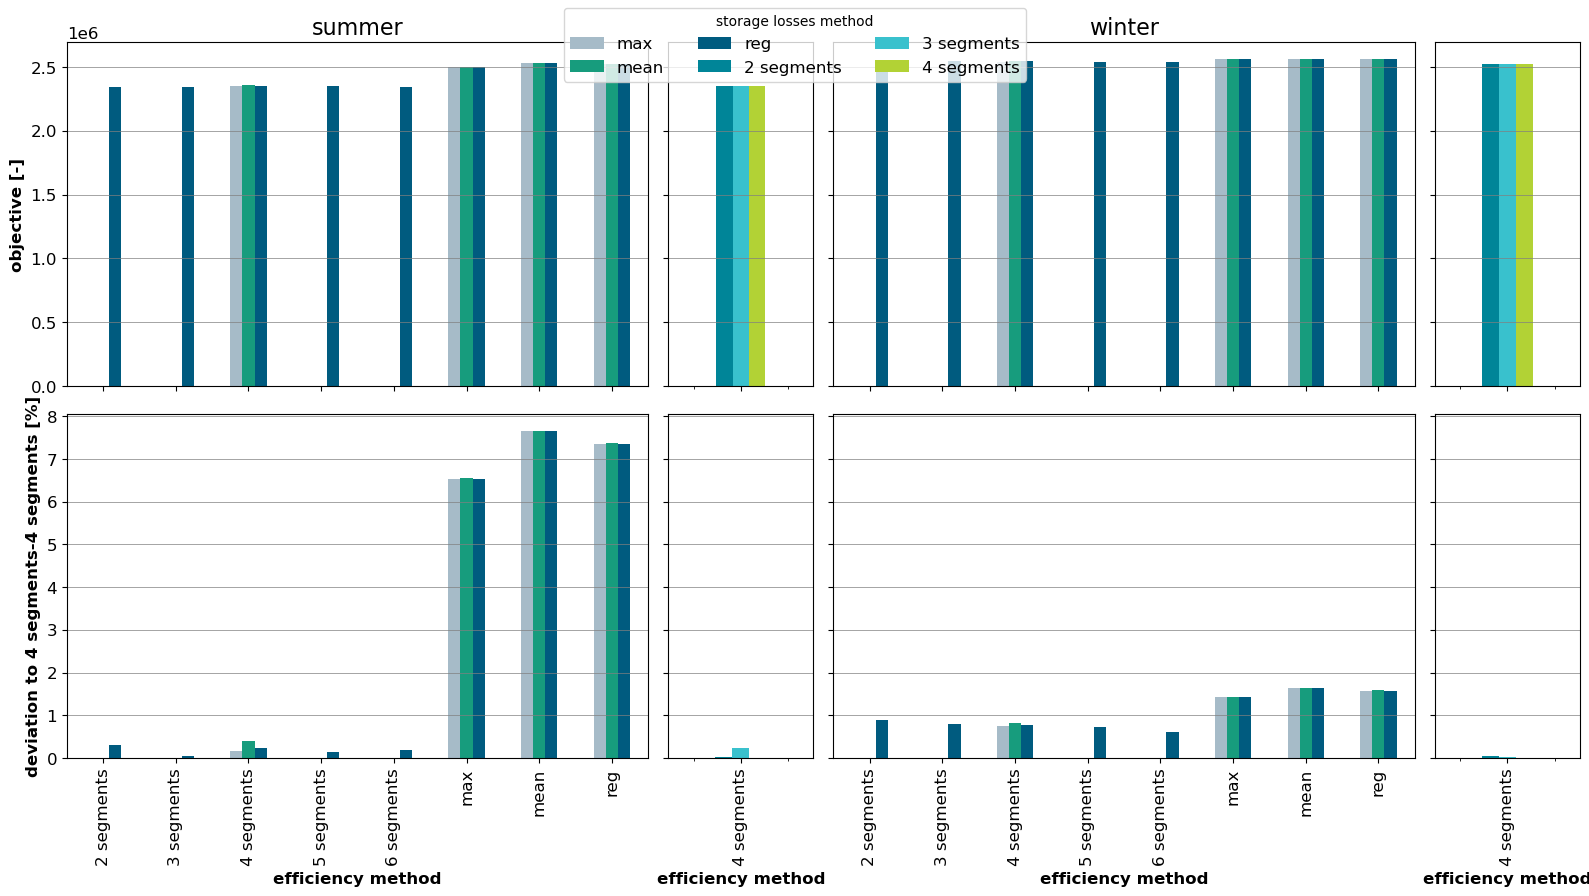

In [7]:
from plots.opt_results_comparison import (
    plot_comparison_optimization_results_caes,
)

type = "objective"
storage_losses_method = (
    "4 segments"  # max, mean, reg, 2 segments, 3 segments, 4 segments
)
efficiency_method = "4 segments"  # linear, 2 segments, 3 segments,..., 10 segments

plot_comparison_optimization_results_caes(
    type, storage_losses_method, efficiency_method
)


It can be seen that the deviations between the implementation of the storage efficiency as constant (max, mean or reg) and the implementation as piecewise linear (2, 3 or 4 segments) are less than 1 % and therefore lie within the MIP gap. The implementation of the charging or discharging efficiency as constant, on the other hand, leads to deviations greater than 1 %, whereby the target function values are greater than with the piecewise linear implementation.

> it should be considered to use piecewise linear approximations to calculate the charging and discharging efficiency

### simulation of storage schedules

Due to the high computing times of the CAES simulation model, it was unfortunately no longer possible to simulate and compare the timetables from the optimisation calculations within the project duration.